### Importing Libraries

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import anderson
from scipy.stats import kruskal



### Data Reading

In [28]:
d= pd.read_excel('SeoulBikeData.xlsx')
d['Date']= pd.to_datetime(d['Date'])
print(d.columns)

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')


c:\Users\sehosseini\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '13/12/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\sehosseini\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '14/12/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\sehosseini\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '15/12/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
c:\Users\sehosseini\Anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '16/12/2017' in DD/MM/YYYY format. Prov

In [4]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [5]:
d.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-01-12 00:00:00,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-01-12 00:00:00,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-01-12 00:00:00,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-01-12 00:00:00,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-01-12 00:00:00,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Phase 1

### Part 1

Here we analyze the count of rented bikes.

#### Histogram

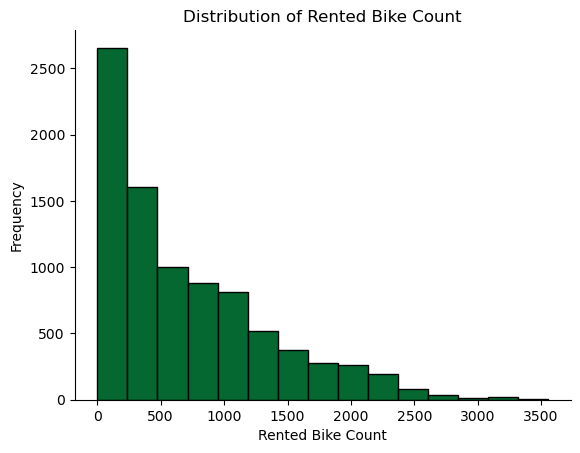

In [23]:
import matplotlib.pyplot as plt

plt.hist(d['Rented Bike Count'], bins=15, color='#046830', edgecolor='black')

# Set title and labels
plt.title('Distribution of Rented Bike Count')
plt.xlabel('Rented Bike Count')
plt.ylabel('Frequency')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show();


We can see from the histogram that for most of the days, the bike demand has been less than 1000 bikes per day.
Also we have some days that the demand was higher than usual around 3000.

#### Hourly Trend

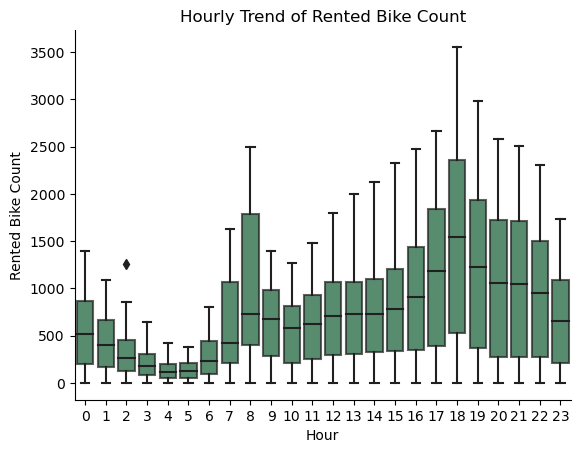

In [55]:

# Set the color palette
sns.set_palette(sns.color_palette(['#046830']))

sns.boxplot(x=d['Hour'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            boxprops=dict(alpha=.7))

# Set title and labels
plt.title('Hourly Trend of Rented Bike Count')
plt.xlabel('Hour')
plt.ylabel('Rented Bike Count')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

We can see that the hourly demand for the bikes has two peaks. The first one is in the morning when people go to work and the second one is around the hour 19 at night when people come back from work.

#### Seasonal Trend

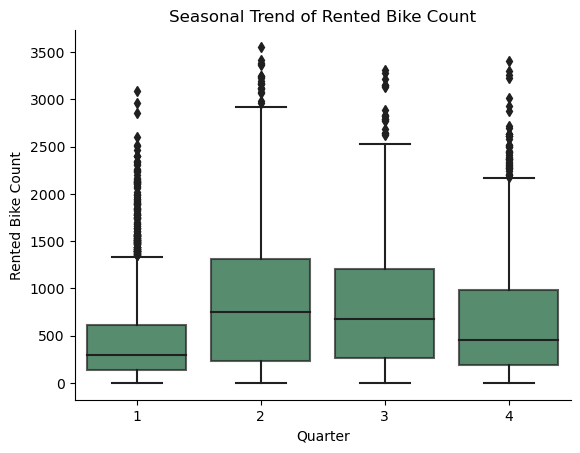

In [61]:
d['Quarter']= d['Date'].dt.quarter

sns.boxplot(x=d['Quarter'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            boxprops=dict(alpha=.7))

# Set title and labels
plt.title('Seasonal Trend of Rented Bike Count')
plt.xlabel('Quarter')
plt.ylabel('Rented Bike Count')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show();

We can see that bikes has higher demand in summer and fall. Surprisingly, the demand in the spring is the lowest althogh the weather situation in this season is suitable for biking.

#### Weekly Trend

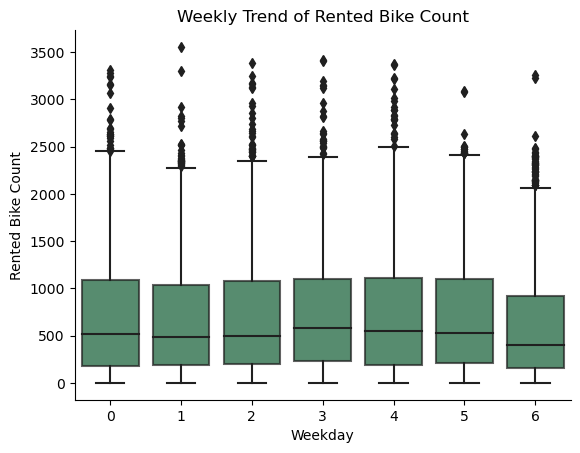

In [63]:
d['Weekday']= d.Date.dt.weekday

sns.boxplot(x=d['Weekday'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            boxprops=dict(alpha=.7))

# Set title and labels
plt.title('Weekly Trend of Rented Bike Count')
plt.xlabel('Weekday')
plt.ylabel('Rented Bike Count')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


We can see that the boxplot can't show the difference between the days well. So we use the simple line chart for this part.

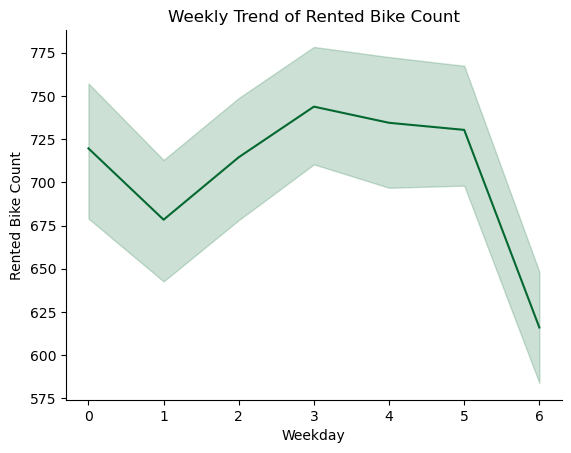

In [64]:
sns.lineplot(x=d['Weekday'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            )

# Set title and labels
plt.title('Weekly Trend of Rented Bike Count')
plt.xlabel('Weekday')
plt.ylabel('Rented Bike Count')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


We can see from the line chart that the demand for working days is usually higher than weeekends. Interestingly, we can see that people do not prefer to bike in the first working days as they may be still tired after the weekends! So the ending working days have the highest demand.

### Part 2

#### Checking Normality

from the previous part, we can see that the demand doesn't have normal distribution. We use Anderson-Darling test to validate this observation.

In [72]:

rented_bike_count = d['Rented Bike Count']

# Perform Anderson-Darling test
result = anderson(rented_bike_count)

# Display the test results in a table
columns = ['Statistic', 'Critical Values', 'Significance Levels']
data = [result.statistic, result.critical_values, result.significance_level]
table_data = pd.DataFrame(data, index=columns, columns=['Value'])

# Print the table
print("Anderson-Darling Test Results for 'Rented Bike Count':")
print(table_data)


Anderson-Darling Test Results for 'Rented Bike Count':
                                                   Value
Statistic                                     311.375046
Critical Values      [0.576, 0.656, 0.787, 0.918, 1.092]
Significance Levels          [15.0, 10.0, 5.0, 2.5, 1.0]


The null hypothesis for the Anderson test is that the sample has normal distribution. Since this hypothesis is strongly rejected since 311>>1.092, we can validate our observation that the demand doesn't have normal distribution. So in the next part, we use Kruskal-Wallis test to check demand difference between holidays and working days.

#### Holiday Effect

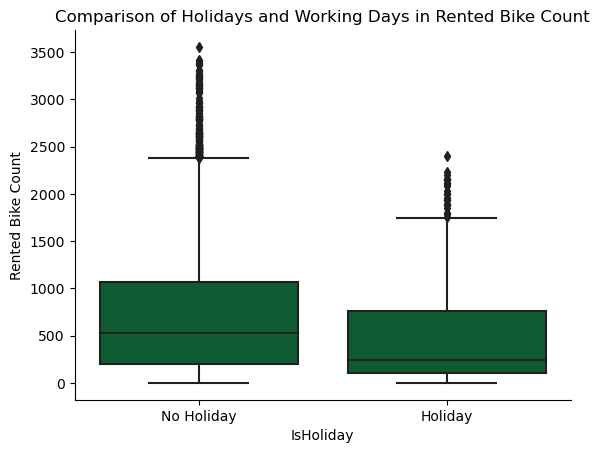

In [75]:
sns.boxplot(x=d['Holiday'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            )

# Set title and labels
plt.title('Comparison of Holidays and Working Days in Rented Bike Count')
plt.xlabel('IsHoliday')
plt.ylabel('Rented Bike Count')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


From the plot we can see that the bike demand on working days is higher than holidays. We the similar results in the weekly trend in the previous part. As also mentioned there, this fact shows that people mostly use bikes to go or come back from work.

In [78]:
holiday_data = [d['Rented Bike Count'][d['Holiday'] == 'Holiday'], d['Rented Bike Count'][d['Holiday'] == 'No Holiday']]

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*holiday_data)

# Display the test results in a table
columns = ['Statistic', 'p-value']
data = [statistic, p_value]
table_data = pd.DataFrame(data, index=columns, columns=['Value'])

# Print the table
print("Kruskal-Wallis Test Results for Rented Bike Count and Holiday:")
print(table_data)


Kruskal-Wallis Test Results for Rented Bike Count and Holiday:
                  Value
Statistic  7.188621e+01
p-value    2.279720e-17


This test is a non-parametric test and it's null hypothesis is that the medians of bike rental counts are equal across different holiday categories. We can see that the p-value is approximately zero, so we reject the null hypothesis and we can say that based on the test, the medians are not equal and there is a difference for the demand between holidays and working days.

### Part 3

#### Correlation Analysis

In [79]:
d.columns

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'Quarter', 'Weekday'],
      dtype='object')

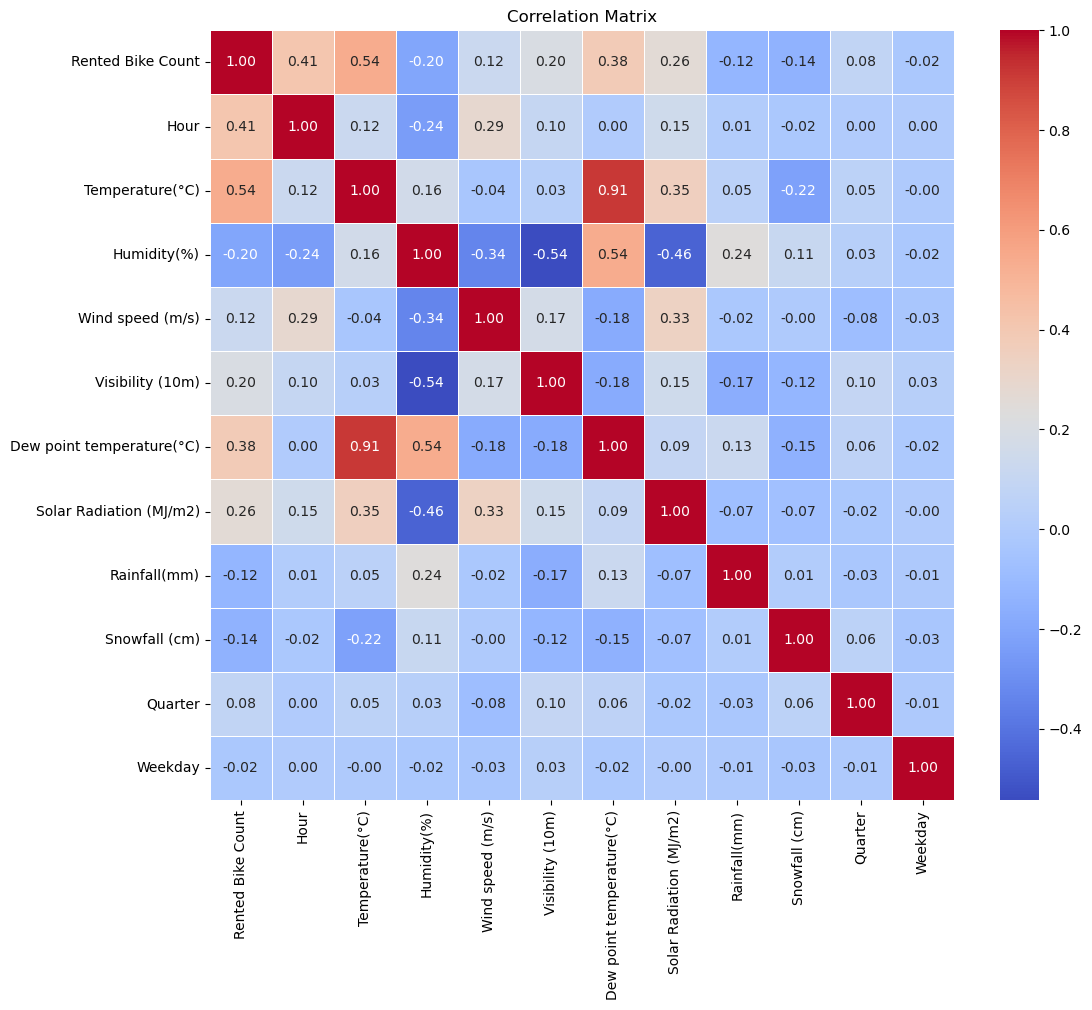

In [82]:
# Assuming df is your DataFrame
correlation_matrix = d.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Set title
plt.title('Correlation Matrix')

# Show the plot
plt.show()


The above plot shows the correlation matrix of the numeric variables. The things is that to train the lasso model, we also need the non-numeric variables. So we first find these columns and then tranform them and then use them for training. 

In [83]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8760 non-null   datetime64[ns]
 1   Rented Bike Count          8760 non-null   int64         
 2   Hour                       8760 non-null   int64         
 3   Temperature(°C)            8760 non-null   float64       
 4   Humidity(%)                8760 non-null   int64         
 5   Wind speed (m/s)           8760 non-null   float64       
 6   Visibility (10m)           8760 non-null   int64         
 7   Dew point temperature(°C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)    8760 non-null   float64       
 9   Rainfall(mm)               8760 non-null   float64       
 10  Snowfall (cm)              8760 non-null   float64       
 11  Seasons                    8760 non-null   object        
 12  Holida

So first we classify the features.

In [90]:
cols_numeric= d.select_dtypes([int, float]).columns.tolist()
print(d.select_dtypes([int, float]).columns)

Index(['Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Quarter',
       'Weekday'],
      dtype='object')


We see some of these columns are not really numeric like hour, quarter, and weekday. We seperate them first.

In [92]:
cols_numeric_cat= ['Hour', 'Quarter', 'Weekday']
cols_numeric= list(set(cols_numeric)- set(cols_numeric_cat))

In [107]:
cols_cat= d.select_dtypes(['object']).columns.tolist()

# we also have quarter in the season column so we remove that
cols_cat= list(set(cols_cat)| set(cols_numeric_cat)- {'Quarter'})

Now we have the final list of categorical columns. So we use them all for the one-hot encoding. We then append the one-hot encoded data to the existing data. We then use this dataframe to train on the encoded and numeric columns.

In [117]:
d_onehot= pd.get_dummies(d[cols_cat].astype(str))
dt= pd.concat([d, d_onehot], axis= 1)
cols_train= list(set(cols_numeric+ d_onehot.columns.tolist()))

In [119]:
print('number of training columns', len(cols_train))
cols_train

number of training columns 48


['Solar Radiation (MJ/m2)',
 'Functioning Day_Yes',
 'Hour_15',
 'Wind speed (m/s)',
 'Rented Bike Count',
 'Hour_20',
 'Weekday_0',
 'Dew point temperature(°C)',
 'Hour_0',
 'Hour_18',
 'Hour_17',
 'Weekday_1',
 'Humidity(%)',
 'Temperature(°C)',
 'Seasons_Winter',
 'Holiday_No Holiday',
 'Hour_14',
 'Rainfall(mm)',
 'Holiday_Holiday',
 'Hour_23',
 'Hour_9',
 'Hour_13',
 'Functioning Day_No',
 'Hour_1',
 'Hour_22',
 'Hour_10',
 'Snowfall (cm)',
 'Visibility (10m)',
 'Hour_3',
 'Hour_7',
 'Hour_5',
 'Hour_11',
 'Hour_8',
 'Seasons_Summer',
 'Weekday_6',
 'Seasons_Spring',
 'Hour_21',
 'Hour_16',
 'Hour_12',
 'Hour_19',
 'Hour_4',
 'Seasons_Autumn',
 'Weekday_3',
 'Weekday_4',
 'Hour_2',
 'Weekday_5',
 'Weekday_2',
 'Hour_6']